# Importing the libraries
We will be needing the following libraries. Make sure you install NumPy, Pandas, Keras, Matplotlib and OpenCV before implementing the following code.

In [38]:
import numpy as np 
import matplotlib.pyplot as plt 
import keras 
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten 
from keras.layers.convolutional import Conv2D, MaxPooling2D 
from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical 
from keras.preprocessing.image import ImageDataGenerator 
import pickle 
import pandas as pd 
import random 
import cv2 

np.random.seed(0) 


In [39]:
# Read data 
data = pd.read_csv("signnames.csv") 
df = data['SignName'].values.tolist()
num_classes = len(df)

with open('train.p', 'rb') as f: 
    train_data = pickle.load(f) 
with open('valid.p', 'rb') as f: 
    val_data = pickle.load(f) 
with open('test.p', 'rb') as f: 
    test_data = pickle.load(f) 

# Extracting the labels from the dictionaries 
X_train, y_train = train_data['features'], train_data['labels'] 
X_val, y_val = val_data['features'], val_data['labels'] 
X_test, y_test = test_data['features'], test_data['labels'] 

# Printing the shapes 
print(X_train.shape) 
print(X_val.shape) 
print(X_test.shape) 


(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [40]:
def preprocessing(img): 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    img = cv2.equalizeHist(img) 
    img = img / 255
    return img 

X_train = np.array(list(map(preprocessing, X_train))) 
X_val = np.array(list(map(preprocessing, X_val))) 
X_test = np.array(list(map(preprocessing, X_test))) 

X_train = X_train.reshape(34799, 32, 32, 1) 
X_val = X_val.reshape(4410, 32, 32, 1) 
X_test = X_test.reshape(12630, 32, 32, 1) 


In [41]:
datagen = ImageDataGenerator(width_shift_range = 0.1, 
                height_shift_range = 0.1, 
                zoom_range = 0.2, 
                shear_range = 0.1, 
                rotation_range = 10) 
datagen.fit(X_train) 

y_train = to_categorical(y_train, num_classes) 
y_val = to_categorical(y_val, num_classes) 
y_test = to_categorical(y_test, num_classes) 


In [42]:
def cnn_model(): 
    model = Sequential() 
    model.add(Conv2D(60, (5, 5), 
                    input_shape =(32, 32, 1), 
                    activation ='relu')) 

    model.add(Conv2D(60, (5, 5), activation ='relu')) 
    model.add(MaxPooling2D(pool_size =(2, 2))) 
    
    model.add(Conv2D(30, (3, 3), activation ='relu')) 
    model.add(Conv2D(30, (3, 3), activation ='relu')) 
    model.add(MaxPooling2D(pool_size =(2, 2))) 
    
    model.add(Flatten()) 
    model.add(Dense(500, activation ='relu')) 
    model.add(Dropout(0.5)) 
    model.add(Dense(num_classes, activation ='softmax')) 
    
    # Compile model 
    model.compile(Adam(lr = 0.001), 
                loss ='categorical_crossentropy', 
                metrics =['accuracy']) 
    return model 

model = cnn_model() 
history = model.fit_generator(datagen.flow(X_train, y_train, 
                            batch_size = 50), steps_per_epoch = 2000/5, 
                            epochs = 10, validation_data =(X_val, y_val), 
                            shuffle = 1) 

model.save('mymodel.hdf5')

with open('history.csv', 'w') as f: 
    history_df = pd.DataFrame(history.history).to_csv(f) 


Epoch 1/10
400/400 [==============================] - 43s 107ms/step - loss: 3.0540 - accuracy: 0.1793 - val_loss: 0.7745 - val_accuracy: 0.7673
Epoch 2/10
400/400 [==============================] - 39s 97ms/step - loss: 1.1673 - accuracy: 0.6474 - val_loss: 0.2987 - val_accuracy: 0.9152
Epoch 3/10
400/400 [==============================] - 43s 107ms/step - loss: 0.7160 - accuracy: 0.7785 - val_loss: 0.2114 - val_accuracy: 0.9392
Epoch 4/10
400/400 [==============================] - 39s 97ms/step - loss: 0.5151 - accuracy: 0.8449 - val_loss: 0.1349 - val_accuracy: 0.9546
Epoch 5/10
400/400 [==============================] - 42s 104ms/step - loss: 0.4127 - accuracy: 0.8700 - val_loss: 0.1145 - val_accuracy: 0.9635
Epoch 6/10
400/400 [==============================] - 40s 99ms/step - loss: 0.3543 - accuracy: 0.8903 - val_loss: 0.1069 - val_accuracy: 0.9717
Epoch 7/10
400/400 [==============================] - 41s 102ms/step - loss: 0.2991 - accuracy: 0.9098 - val_loss: 0.0950 - val_accur

In [43]:
loadedModel = keras.models.load_model('mymodel.hdf5')

loadedHistory = pd.read_csv('history.csv')

Text(0.5, 0, 'epoch')

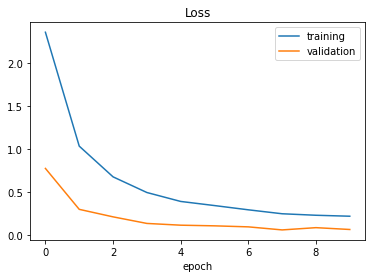

In [44]:
plt.plot(loadedHistory['loss']) 
plt.plot(loadedHistory['val_loss']) 
plt.legend(['training', 'validation']) 
plt.title('Loss') 
plt.xlabel('epoch') 

Text(0.5, 0, 'epoch')

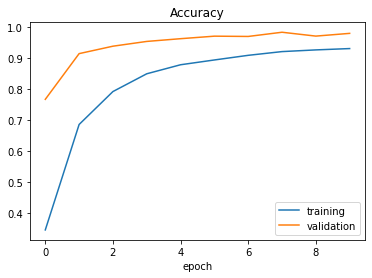

In [45]:
plt.plot(loadedHistory['accuracy']) 
plt.plot(loadedHistory['val_accuracy']) 
plt.legend(['training', 'validation']) 
plt.title('Accuracy') 
plt.xlabel('epoch') 

In [46]:
score = loadedModel.evaluate(X_test, y_test, verbose = 0) 
print('Test Loss: ', score[0]) 
print('Test Accuracy: ', score[1]) 


Test Loss:  0.15018390119075775
Test Accuracy:  0.9566904306411743


Predicted sign: Speed limit (20km/h)


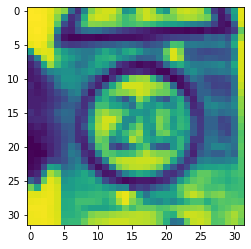

In [47]:
plt.imshow(X_test[990].reshape(32, 32)) 
print("Predicted sign: "+ df[int( 
        loadedModel.predict_classes(X_test[990].reshape(1, 32, 32, 1)))]) 
